In [19]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from utils import *
from env import Environment
from main import Config
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Baseline: Fictitious Play Solving Two-Agents Dilemma
Payoff matrix:

| Tables      | Cooperation |  Defection |
|-------------|:-----------:|-----------:|
| Cooperation |   REWARD    | TEMPTATION |
| Defection   |   SUCKER    | PUNISHMENT |

In [2]:
N_EPISODES = 100
EPOCH = 100
seed = 42
np.random.seed(seed)

In [3]:
def two_agent_fictitious_play(payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, epsilon:float=0.05, random:bool=False):
    # exploration
    for i in range(1,10):
        strategy[i,0] = np.random.randint(0,2)
        strategy[i,1] = np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

    for i in range(10,N_EPISODES):
        # calculate payoff of Agent 0 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[i-1,1]*payoff[0,1] + (1-belief[i-1,1])*payoff[0,0]
        reward[1,0] = belief[i-1,1]*payoff[1,1] + (1-belief[i-1,1])*payoff[1,0]

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[i-1,0]*payoff[0,1] + (1-belief[i-1,0])*payoff[0,0]
        reward[1,1] = belief[i-1,0]*payoff[1,1] + (1-belief[i-1,0])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,0] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,0] = 0
        else:
            strategy[i,0] = strategy[i-1,0] if random==False else np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,1] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,1] = 0
        else:
            strategy[i,1] = strategy[i-1,1] if random==False else np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    return strategy, belief

In [4]:
def generate_payoff_matrix(name:str, REWARD=3, TEMPTATION=None, SUCKER=None, PUNISHMENT=1, N=100):
    # prisoner's dilemma rule: TEMPTATION > REWARD > PUNISHMENT > SUCKER; 2*REWARD > TEMPTATION + SUCKER
    if REWARD is not None and TEMPTATION is not None and SUCKER is not None and PUNISHMENT is not None:
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT
    if name == 'PD':
        TEMPTATION = np.round(np.random.uniform(REWARD+0.01, 2*REWARD-0.01, N), decimals=2)
        x = np.ones(N)
        REWARD = REWARD * x
        SUM = np.round(np.random.uniform(TEMPTATION, 2*REWARD-0.01, N), decimals=2)
        SUCKER = SUM - TEMPTATION
        PUNISHMENT = np.round(np.random.uniform(SUCKER+0.01, REWARD-0.01, N), decimals=2)
        assert np.sum(TEMPTATION > REWARD) == N and np.sum(REWARD > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(TEMPTATION > REWARD)} and {np.sum(REWARD > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
        assert np.sum(2*REWARD > TEMPTATION + SUCKER) == N, f'{np.sum(2*REWARD > TEMPTATION + SUCKER)}'
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT
    if name == 'SH':
        # stag hunt rule: REWARD > TEMPTATION > PUNISHMENT > SUCKER; TEMPTATION + SUCKER > 2*PUNISHMENT
        x = np.ones(N)
        PUNISHMENT = PUNISHMENT * x
        SUCKER = np.round(np.random.uniform(0, PUNISHMENT-0.01, N), decimals=2)
        TEMPTATION = np.round(np.random.uniform(2*PUNISHMENT-SUCKER+0.01, 10-0.01, N), decimals=2)
        REWARD = np.round(np.random.uniform(TEMPTATION+0.01, 10, N), decimals=2)
        assert np.sum(REWARD > TEMPTATION) == N and np.sum(TEMPTATION > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(REWARD > TEMPTATION)} and {np.sum(TEMPTATION > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT
    
def simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT):
    # C:0, D:1
    df_result = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
        payoff = np.array([[R, S],[T, P]])
        strategy_list, belief_list = [],[]
        for ep in range(EPOCH):
            # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
            reward = np.zeros([2,2])
            # 'strategy' stores the strategy played in each time period
            strategy = -np.ones([N_EPISODES,2])
            # 'belief' stores the empirical distribution at each time period, which is the defection probability
            belief = np.zeros([N_EPISODES,2])
            strategy, belief = two_agent_fictitious_play(payoff, reward, strategy, belief, epsilon=0)
            strategy_list.append(strategy[-1].copy())
            belief_list.append(belief[-1].copy())
        df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief'])
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_result = pd.concat([df_result, df_mean], ignore_index=True)
    return df_result.astype(float)

PD results

1000it [02:04,  8.04it/s]


<AxesSubplot:ylabel='Frequency'>

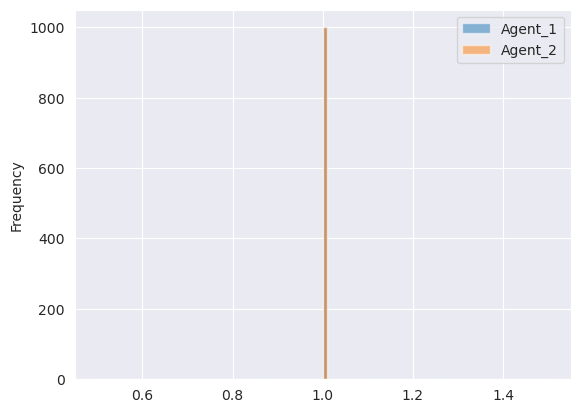

In [5]:
# prisoner's dilemma
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 5, 0, 1
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0
# payoff matrix for the two Agents in the 2x2 game
df_PD = simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
df_PD[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

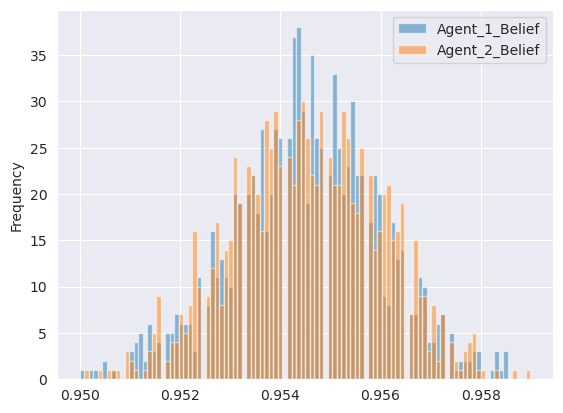

In [6]:
df_PD[['Agent_1_Belief', 'Agent_2_Belief']].plot.hist(bins=100, alpha=0.5)

Stag Hunt result

1000it [02:21,  7.08it/s]


<AxesSubplot:ylabel='Frequency'>

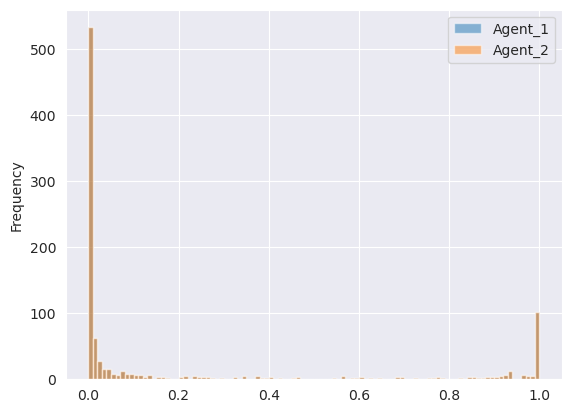

In [7]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1

df_SH = simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
df_SH[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

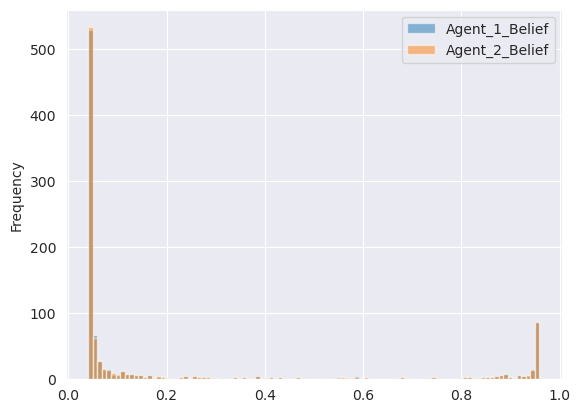

In [8]:
df_SH[['Agent_1_Belief', 'Agent_2_Belief']].plot.hist(bins=100, alpha=0.5)

In [9]:
df_SH.where((df_SH['Agent_1'] < 0.9) & (df_SH['Agent_1'] > 0.1)).dropna()

,Agent_1,Agent_2,Agent_1_Belief,Agent_2_Belief,temptation,reward,punishment,sucker
0,0.42,0.42,0.429697,0.427980,9.55,9.84,1.0,0.74
1,0.75,0.75,0.724646,0.725859,5.20,5.52,1.0,0.56
8,0.70,0.70,0.678788,0.679798,9.24,9.99,1.0,0.12
12,0.16,0.16,0.192626,0.194444,7.55,8.10,1.0,0.64
28,0.16,0.16,0.192828,0.190808,9.18,9.85,1.0,0.53
...,...,...,...,...,...,...,...,...
974,0.83,0.83,0.796970,0.799697,6.51,6.89,1.0,0.51
978,0.86,0.86,0.823636,0.823434,9.40,9.95,1.0,0.11
980,0.11,0.11,0.145859,0.145758,8.66,9.88,1.0,0.20
982,0.24,0.24,0.264141,0.264242,5.26,6.52,1.0,0.05


(0.0, 3.5)

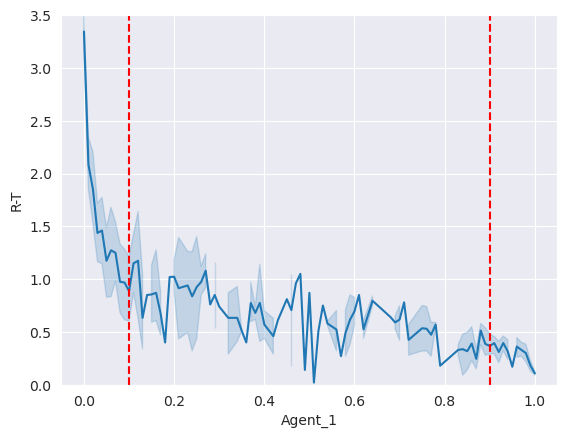

In [10]:
df_SH_convergent = df_SH.where((df_SH['Agent_1'] >= 0.9) | (df_SH['Agent_1'] <= 0.1)).dropna()
df_SH['R-T'] = df_SH['reward'] - df_SH['temptation']
sns.lineplot(data=df_SH, x='Agent_1', y='R-T')
plt.vlines(0.1, -0, 3.5, 'r', '--')
plt.vlines(0.9, -0, 3.5, 'r', '--')
plt.ylim(0,3.5)

(0.0, 8.295000000000002)

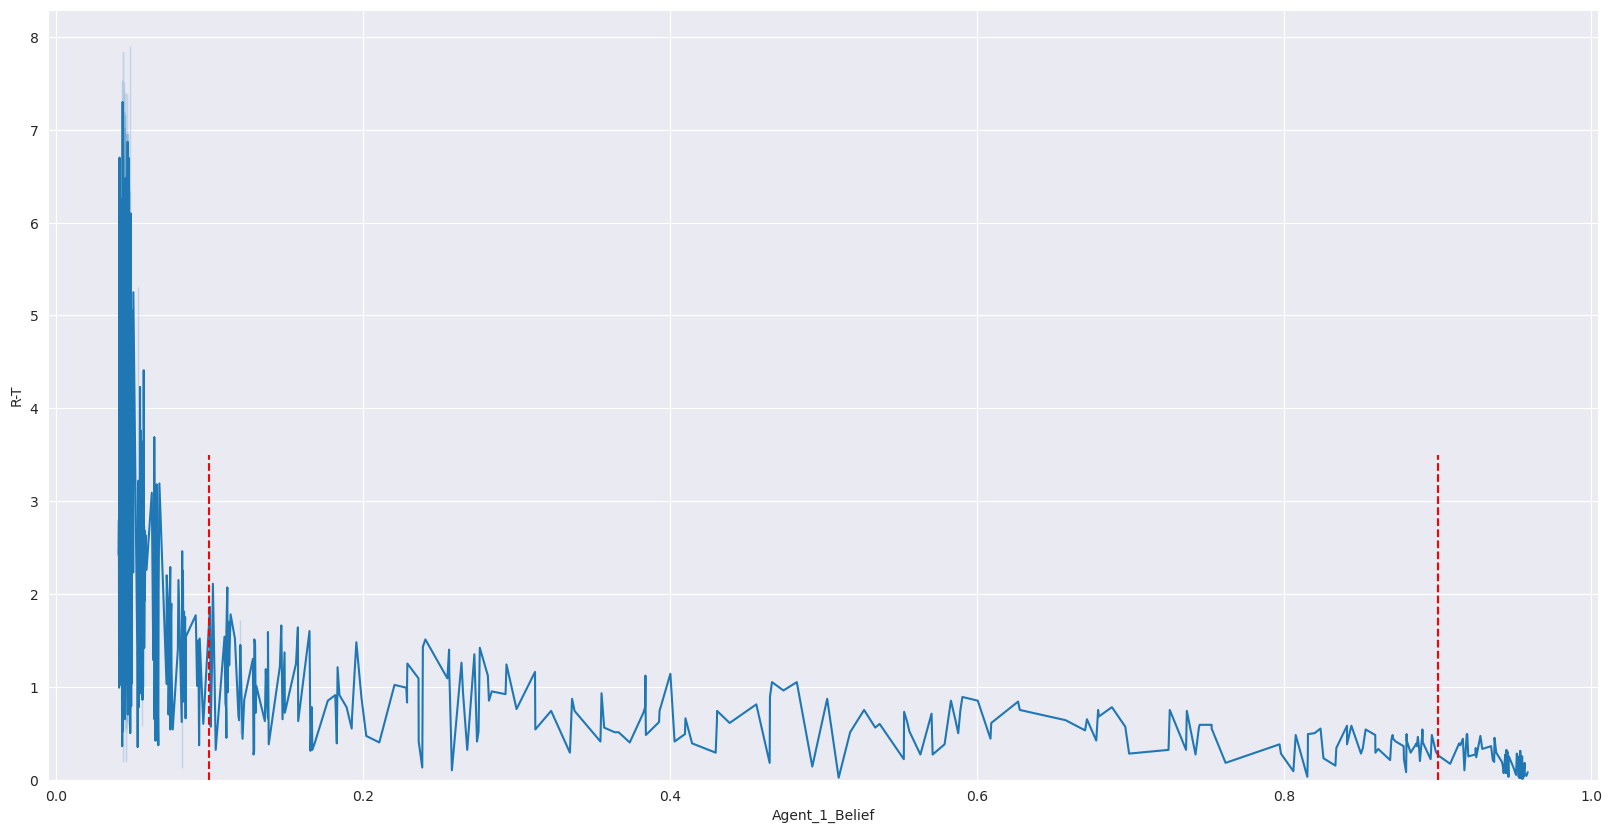

In [11]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_SH, x='Agent_1_Belief', y='R-T')
plt.vlines(0.1, -0, 3.5, 'r', '--')
plt.vlines(0.9, -0, 3.5, 'r', '--')
plt.ylim(0,)

(0.0, 10.0)

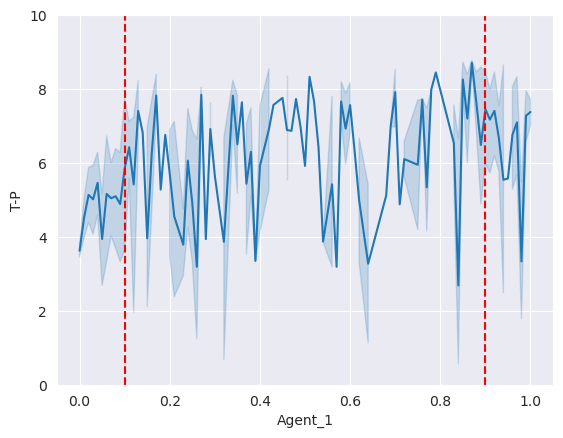

In [12]:
df_SH['T-P'] = df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='T-P')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(0,10)

(0.0, 1.0)

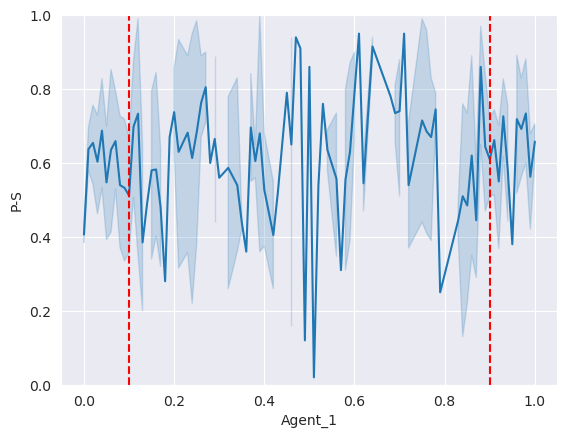

In [13]:
df_SH['P-S'] = df_SH['punishment'] - df_SH['sucker']
sns.lineplot(data=df_SH, x='Agent_1', y='P-S')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(0,1)

### Generalized into N-Agent Version

In [98]:
def multi_agent_fictitious_play(N_EPISODES:int, payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, N:int, alpha:float=0.05, epsilon:float=0.05, entropy_flag:bool=False):

    def entropy(p:float):
        return -np.sum(p * np.log(p + 1e-6))

    def random_select_partner(N:int, n:int):
        m = n
        while m == n:
            m = np.random.randint(0, N)
        return m

    def select_partner_entropy(N:int, n:int, belief:Type.TensorType):
        min_en = np.inf
        m = 0
        for i in range(N):
            if i == n:
                continue
            en = entropy(belief.copy()[i])
            if en < min_en:
                min_en= en
                m = i
        return m

    assert strategy.shape == (N_EPISODES, N), f"strategy columns should be {N}, but {strategy.shape}"

    log=dict()
    final_strategy = np.zeros(N)
    # exploration
    for i in range(1,10):
        n = np.random.randint(0, N)
        m = random_select_partner(N,n)

        strategy[i,n] = np.random.randint(0,2)
        strategy[i,m] = np.random.randint(0,2)

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}

    for i in range(10,N_EPISODES):
        n = np.random.randint(0, N)

        if entropy_flag:
            m = select_partner_entropy(N,n,belief)
        else:
            m = random_select_partner(N,n)

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[n]*payoff[0,1] + (1-belief[n])*payoff[0,0]
        reward[1,0] = belief[n]*payoff[1,1] + (1-belief[n])*payoff[1,0]

        # calculate payoff of Agent 2 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[m]*payoff[0,1] + (1-belief[m])*payoff[0,0]
        reward[1,1] = belief[m]*payoff[1,1] + (1-belief[m])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,n] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,n] = 0
        else:
            strategy[i,n] = np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,m] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,m] = 0
        else:
            strategy[i,m] = np.random.randint(0,2)

        print('error') if strategy[i,n]<0 or strategy[i,m]<0 else None

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}
        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    for i in range(N):
        j = -1
        while strategy[j,i] == -1:
            j -= 1
        final_strategy[i] = strategy[j,i]
    return strategy, belief, log, final_strategy

In [99]:
def multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=False):
    payoff = np.array([[REWARD, SUCKER],[TEMPTATION, PUNISHMENT]])
    strategy_list, belief_list = [],[]
    for ep in range(EPOCH):
        # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
        reward = np.zeros([2,2])
        # 'strategy' stores the strategy played in each time period
        strategy = -np.ones([N_EPISODES,N_AGENTS])
        # 'belief' stores the empirical distribution at each time period, which is the defection probability
        belief = np.zeros(N_AGENTS)
        _, belief, belief_log, final_strategy = multi_agent_fictitious_play(N_EPISODES, payoff, reward, strategy, belief, N_AGENTS, entropy_flag=entropy_flag)
        strategy_list.append(final_strategy.copy())
        belief_list.append(belief.copy())

    columns = []
    for i in range(N):
        columns.append(f'Agent_{i+1}')
    for i in range(N):
        columns.append(f'Agent_{i+1}_Belief')

    df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=columns)
    return df

random partner selection

In [48]:
# prisoner's dilemma
REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3.0, 5.8, 0.1, 3.3	
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 4, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0

EPOCH = 100
N_AGENTS = 3
N_EPISODES = 1000
# C:0, D:1
# payoff matrix for the two players in the 2x2 game
df_multi_PD = multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N_AGENTS, EPOCH)
df_multi_PD.describe()

,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief
count,100.0,100.0,100.0,100.0,100.0,100.0
mean,1.0,1.0,1.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,0.0,0.0,0.0
25%,1.0,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,0.0,0.0,0.0
max,1.0,1.0,1.0,0.0,0.0,0.0


100it [03:56,  2.37s/it]


<AxesSubplot:ylabel='Frequency'>

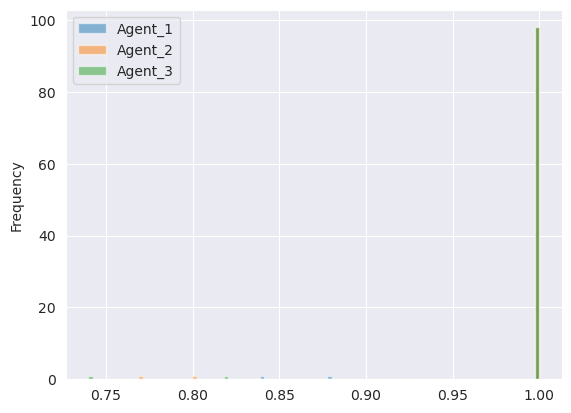

In [23]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
df_multi_PD = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
df_multi_PD = df_multi_PD.astype(float)
df_multi_PD[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

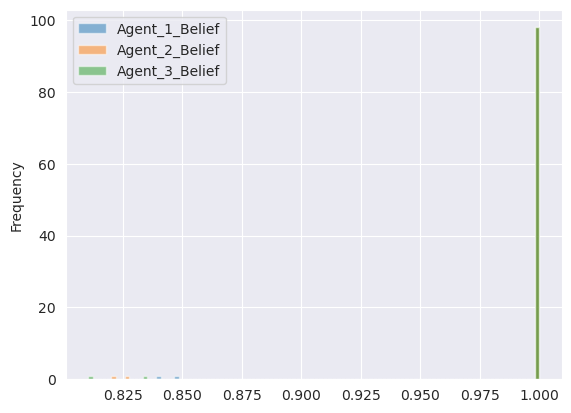

In [24]:
df_multi_PD[['Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief']].plot.hist(bins=100, alpha=0.5)

In [19]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    if sum(df_multi_PD['Agent_1'] < 0.9) >= 10 or sum(df_multi_PD['Agent_1_Belief'] < 0.9) >= 10:
        print(df_multi_PD.mean())

100it [03:47,  2.27s/it]
100it [03:44,  2.25s/it]
100it [03:42,  2.22s/it]
100it [03:40,  2.21s/it]
100it [03:40,  2.21s/it]
100it [03:39,  2.19s/it]


In [127]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
df_multi_SH = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_SH = pd.concat([df_multi_SH, df_mean], ignore_index=True)
df_multi_SH = df_multi_SH.astype(float)
df_multi_SH.describe()

1000it [41:05,  2.47s/it]


,temptation,reward,punishment,sucker,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief
count,1000.000000,1000.000000,1000.0,1000.00000,1000.000000,1000.00000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,5.773210,7.855350,1.0,0.48962,0.075190,0.07519,0.075140,7.522522e-02,7.498189e-02,7.511031e-02
std,2.438745,1.850628,0.0,0.29378,0.235758,0.23640,0.235937,2.357252e-01,2.360539e-01,2.358528e-01
min,1.140000,1.850000,1.0,0.00000,0.000000,0.00000,0.000000,2.533438e-16,2.502147e-16,2.467081e-16
25%,3.640000,6.722500,1.0,0.22000,0.000000,0.00000,0.000000,3.274604e-16,3.273576e-16,3.273531e-16
50%,5.860000,8.345000,1.0,0.48000,0.000000,0.00000,0.000000,3.558929e-16,3.560034e-16,3.548161e-16
75%,7.835000,9.400000,1.0,0.75000,0.000000,0.00000,0.000000,3.935671e-16,3.922767e-16,3.908975e-16
max,9.980000,10.000000,1.0,0.99000,1.000000,1.00000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


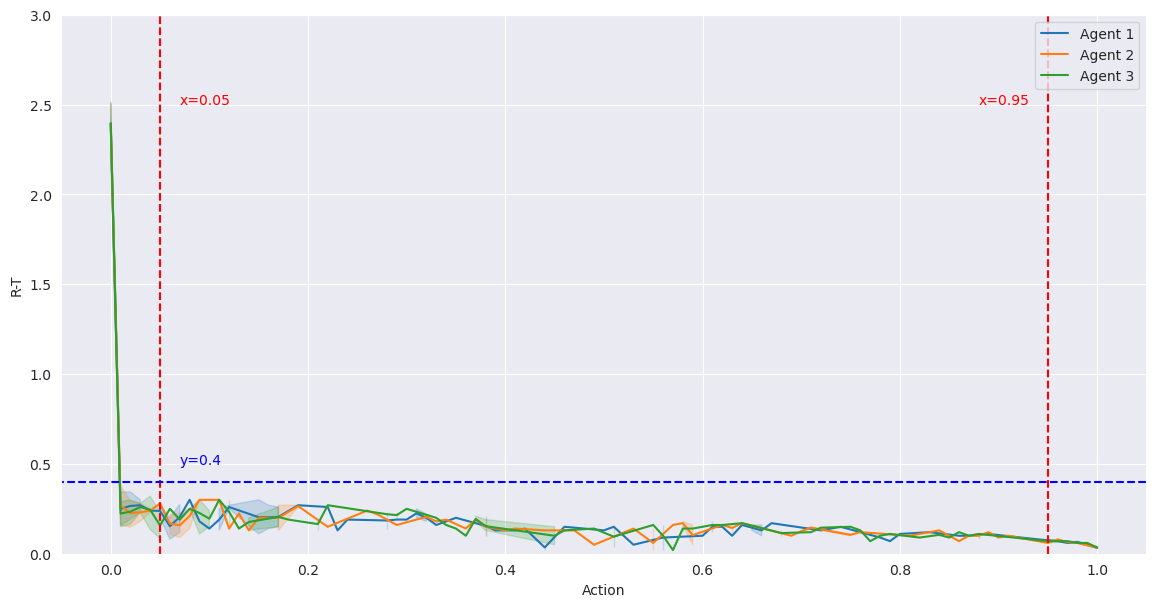

In [131]:
plt.figure(figsize=(14, 7))
df_multi_SH['R-T'] = df_multi_SH['reward'] - df_multi_SH['temptation']
sns.lineplot(data=df_multi_SH, x='Agent_1', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH, x='Agent_2', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH, x='Agent_3', y='R-T', label='Agent 3')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Action')
plt.legend()

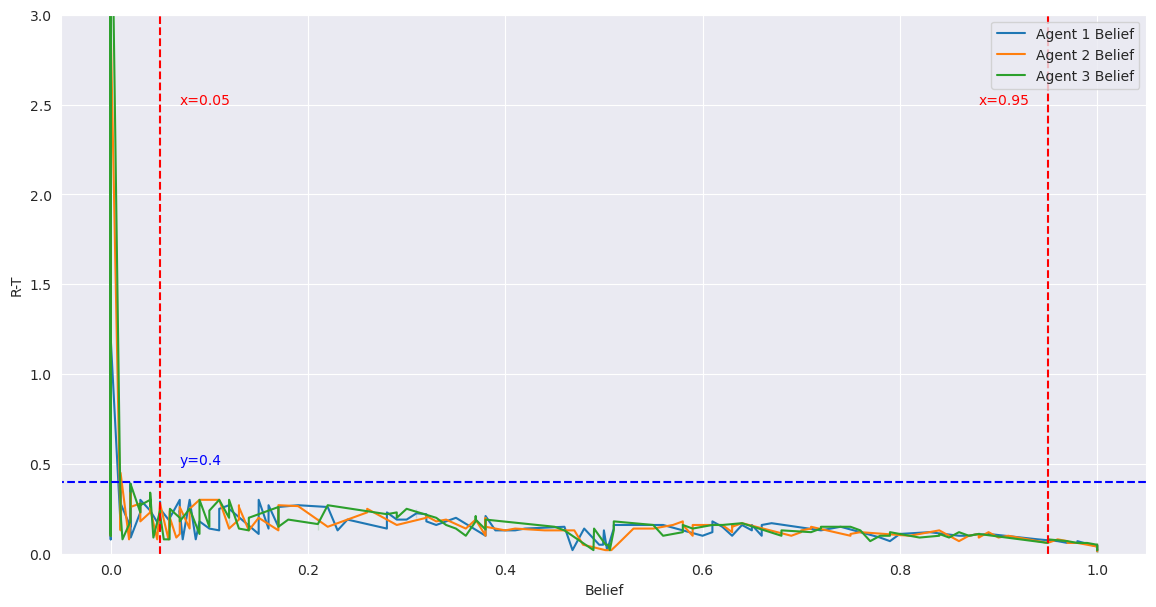

In [132]:
plt.figure(figsize=(14, 7))
df_multi_SH['R-T'] = df_multi_SH['reward'] - df_multi_SH['temptation']
sns.lineplot(data=df_multi_SH, x='Agent_1_Belief', y='R-T', label='Agent 1 Belief')
sns.lineplot(data=df_multi_SH, x='Agent_2_Belief', y='R-T', label='Agent 2 Belief')
sns.lineplot(data=df_multi_SH, x='Agent_3_Belief', y='R-T', label='Agent 3 Belief')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Belief')
plt.legend()

Select partner according to entropy

100it [05:30,  3.30s/it]


<AxesSubplot:ylabel='Frequency'>

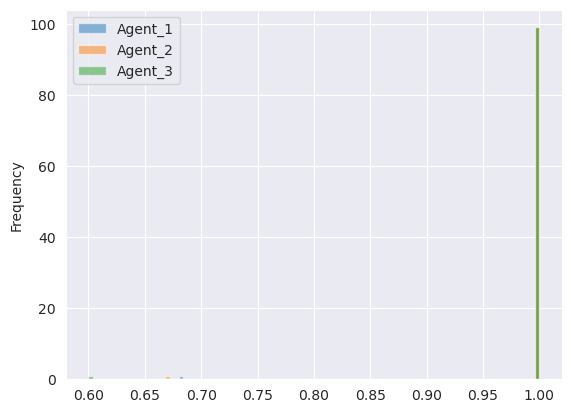

In [61]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
df_multi_PD_entropy = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=True)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_PD_entropy = pd.concat([df_multi_PD_entropy, df_mean], ignore_index=True)
df_multi_PD_entropy = df_multi_PD_entropy.astype(float)
df_multi_PD_entropy[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

In [102]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
df_multi_SH_entropy = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=True)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_SH_entropy = pd.concat([df_multi_SH_entropy, df_mean], ignore_index=True)
df_multi_SH_entropy = df_multi_SH_entropy.astype(float)

1000it [1:16:04,  4.56s/it]


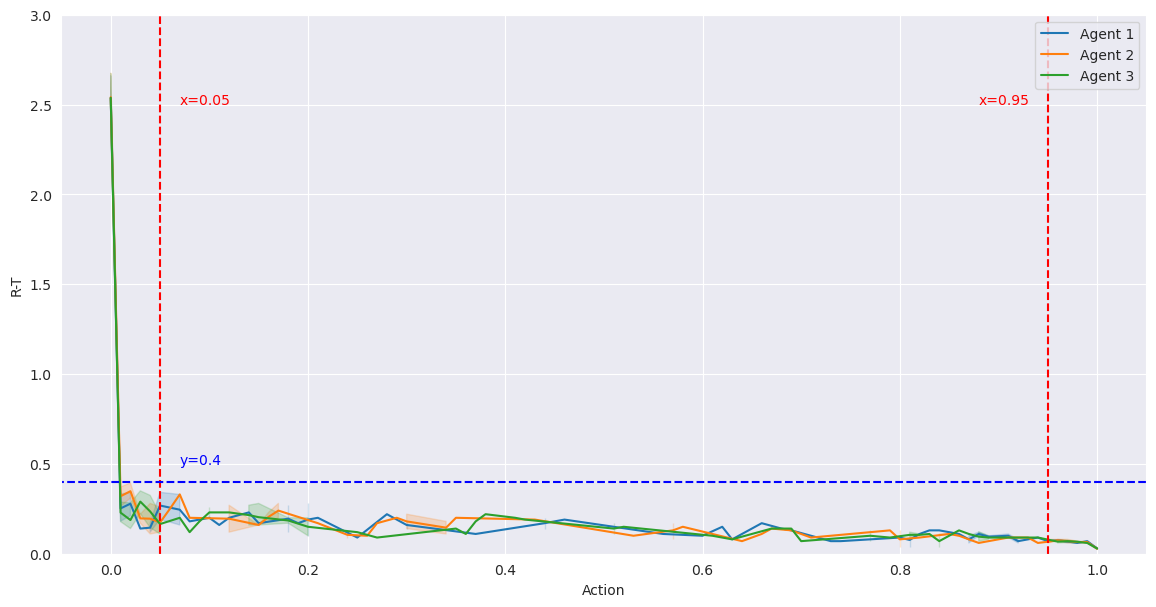

In [133]:
plt.figure(figsize=(14, 7))
df_multi_SH_entropy['R-T'] = df_multi_SH_entropy['reward'] - df_multi_SH_entropy['temptation']
sns.lineplot(data=df_multi_SH_entropy, x='Agent_1', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_2', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_3', y='R-T', label='Agent 3')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.legend()
plt.xlabel('Action')
plt.show()

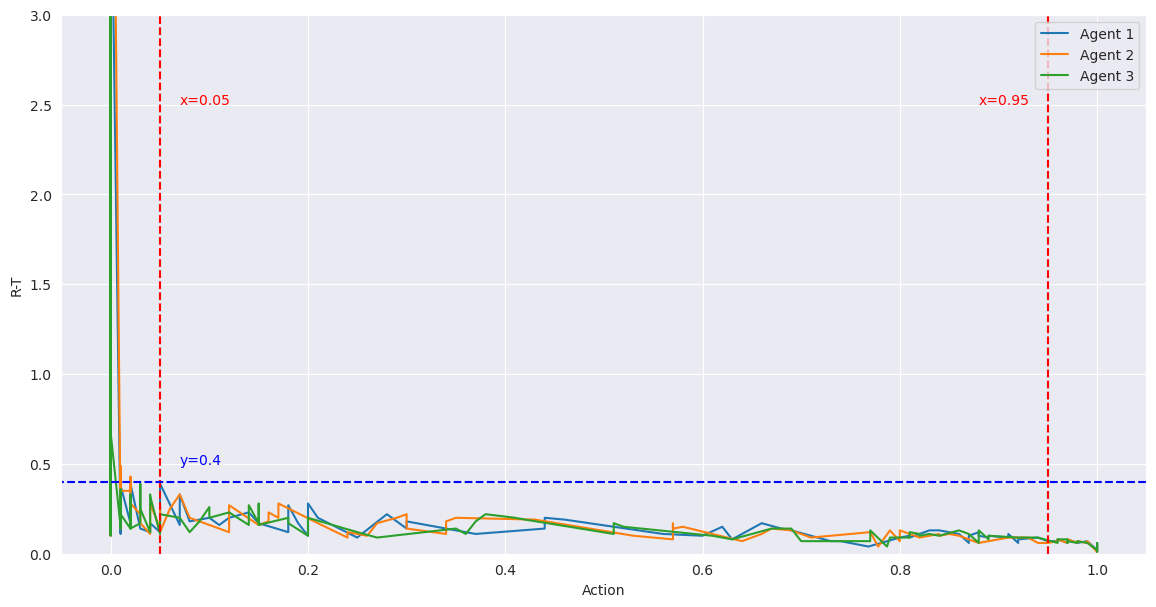

In [134]:
plt.figure(figsize=(14, 7))
df_multi_SH_entropy['R-T'] = df_multi_SH_entropy['reward'] - df_multi_SH_entropy['temptation']
sns.lineplot(data=df_multi_SH_entropy, x='Agent_1_Belief', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_2_Belief', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_3_Belief', y='R-T', label='Agent 3')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.legend()
plt.xlabel('Action')
plt.show()

In [22]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    print(df_multi_PD.mean())

100it [04:05,  2.46s/it]


temptation        5.9338
reward            7.8619
punishment        1.0000
sucker            0.5460
Agent_1           0.0957
Agent_2           0.0957
Agent_3           0.0957
Agent_4           0.0957
Agent_1_Belief    0.0957
Agent_2_Belief    0.0957
Agent_3_Belief    0.0957
Agent_4_Belief    0.0957
dtype: float64


100it [04:03,  2.43s/it]


temptation        5.9338
reward            7.8619
punishment        1.0000
sucker            0.5460
Agent_1           0.0922
Agent_2           0.0922
Agent_3           0.0922
Agent_4           0.0922
Agent_5           0.0922
Agent_1_Belief    0.0922
Agent_2_Belief    0.0922
Agent_3_Belief    0.0922
Agent_4_Belief    0.0922
Agent_5_Belief    0.0922
dtype: float64


100it [03:59,  2.39s/it]


temptation        5.9338
reward            7.8619
punishment        1.0000
sucker            0.5460
Agent_1           0.0906
Agent_2           0.0906
Agent_3           0.0906
Agent_4           0.0906
Agent_5           0.0906
Agent_6           0.0906
Agent_1_Belief    0.0906
Agent_2_Belief    0.0906
Agent_3_Belief    0.0906
Agent_4_Belief    0.0906
Agent_5_Belief    0.0906
Agent_6_Belief    0.0906
dtype: float64


100it [03:56,  2.36s/it]


temptation        5.9338
reward            7.8619
punishment        1.0000
sucker            0.5460
Agent_1           0.0898
Agent_2           0.0898
Agent_3           0.0898
Agent_4           0.0898
Agent_5           0.0898
Agent_6           0.0898
Agent_7           0.0898
Agent_1_Belief    0.0898
Agent_2_Belief    0.0898
Agent_3_Belief    0.0898
Agent_4_Belief    0.0898
Agent_5_Belief    0.0898
Agent_6_Belief    0.0898
Agent_7_Belief    0.0898
dtype: float64


100it [03:54,  2.35s/it]


temptation        5.9338
reward            7.8619
punishment        1.0000
sucker            0.5460
Agent_1           0.0897
Agent_2           0.0897
Agent_3           0.0897
Agent_4           0.0897
Agent_5           0.0897
Agent_6           0.0897
Agent_7           0.0897
Agent_8           0.0897
Agent_1_Belief    0.0897
Agent_2_Belief    0.0897
Agent_3_Belief    0.0897
Agent_4_Belief    0.0897
Agent_5_Belief    0.0897
Agent_6_Belief    0.0897
Agent_7_Belief    0.0897
Agent_8_Belief    0.0897
dtype: float64


100it [03:58,  2.38s/it]

temptation        5.933800
reward            7.861900
punishment        1.000000
sucker            0.546000
Agent_1           0.089800
Agent_2           0.089800
Agent_3           0.089800
Agent_4           0.089800
Agent_5           0.089800
Agent_6           0.089800
Agent_7           0.089800
Agent_8           0.089800
Agent_9           0.089800
Agent_1_Belief    0.089799
Agent_2_Belief    0.089799
Agent_3_Belief    0.089799
Agent_4_Belief    0.089799
Agent_5_Belief    0.089799
Agent_6_Belief    0.089799
Agent_7_Belief    0.089799
Agent_8_Belief    0.089799
Agent_9_Belief    0.089799
dtype: float64
